# FlowKit Tutorial - Part 3 - The `GatingStrategy` & `GatingResults` Classes

https://flowkit.readthedocs.io/en/latest/?badge=latest

So far, we've seen how to load FCS files using the Sample class and perform basic pre-processing like compensation and transformation for better visualization of event data. In part 3, we will explore using FlowKit for gating Sample event data using the `GatingStrategy` and `GatingResults` classes.

If you have any questions about FlowKit, find any bugs, or feel something is missing from these tutorials [please submit an issue to the GitHub repository here](https://github.com/whitews/FlowKit/issues/new/).

## Table of Contents

* [`GatingStrategy` Class](#GatingStrategy-Class)
  * [The Gate ID Concept](#gate-id-concept)
  * [Create a GatingStrategy from a GatingMl-2.0 document](#create-gating-strategy-from-gml)
    * [Retrieve the Gate Hierarchy](#retrieve-gate-hierarchy)
    * [Export Gate Hierarchy as Image](#export-hierarchy-as-image)
    * [Retrieve Gate IDs](#retrieve-gate-ids)
    * [Retrieve Gate Instances](#retrieve-gate-instances)
    * [Retrieve Compensation Matrices](#Retrieve-Compensation-Matrices)
    * [Retrieve Transformations](#Retrieve-Transformations)
* [`GatingResults` Class](#GatingResults-Class)
  * [`GatingResults` Report](#GatingResults-Report)

In [1]:
import bokeh
from bokeh.plotting import show
import matplotlib.pyplot as plt

import flowkit as fk

bokeh.io.output_notebook()
%matplotlib inline

_ = plt.ioff()

Loading BokehJS ...

In [2]:
# check version so users can verify they have the same version/API
fk.__version__

'0.8.2'

## GatingStrategy Class

A GatingStrategy object represents a collection of hierarchical gates along with the compensation and transformation information referenced by any gate Dimension objects (covered in Part 4 of the tutorial series). A GatingStrategy can be created from a valid GatingML document or built programmatically. Methods in the GatingStrategy class fall in to 3 main categories: adding gate-related objects, retrieving those objects, and applying the gating strategy to a Sample.

Let's look at the documentation for the GatingStrategy class:

In [3]:
help(fk.GatingStrategy)

Help on class GatingStrategy in module flowkit._models.gating_strategy:

class GatingStrategy(builtins.object)
 |  Represents a flow cytometry gating strategy, including instructions
 |  for compensation and transformation.
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  add_comp_matrix(self, matrix)
 |      Add a compensation matrix to the gating strategy, see `transforms` module. The matrix ID must be unique in the
 |      gating strategy.
 |      
 |      :param matrix: an instance of the Matrix class
 |      :return: None
 |  
 |  add_gate(self, gate, gate_path=None)
 |      Add a gate to the gating strategy, see `gates` module. The gate ID and gate path must be
 |      unique in the gating strategy. A gate with a unique gate ID and parent can be added without
 |      specifying a gate_path. However, if the gate's ID and parent combination alread

<a id="gate-id-concept"></a>
### The Gate ID Concept

Quite a lot of thought has been put into the design of the GatingStrategy class to support the various ways gates are used and processed in typical FCM workflows. The most important concept to understand when interacting with a GatingStrategy instance is how gate IDs are used to reference gates and their position within the gating hierarchy. 

For example, gates are sometimes "re-used" in different branches of the hierarchy, like the same quadrant gate applied to each of the CD4+ and CD8+ populations. Because of this, the name of the gate is not sufficient to fully identify it. Further, simply coupling the gate name with its parent gate name can also become problematic if the nested gates are re-used.

The GatingStrategy class solves this ambiguity by defining a gate ID as a tuple combining the gate name and the full ancestor path of gate names, similar in concept to a computer file system. However, this approach can be cumbersome for the common case where gates are not re-used. Therefore, the GatingStrategy allows for referencing gates simply by their gate name string for cases where that name is not re-used within the gate hierarchy. For ambiguous cases, referencing a gate requires the full gate ID tuple of the gate name and gate path. 

We will see how this works in practice later, but for now let's create a GatingStrategy from an existing GatingML-2.0 document.

<a id="create-gating-strategy-from-gml"></a>
### Create a GatingStrategy from a GatingML-2.0 Document

In [4]:
gml_path = '../examples/data/8_color_data_set/8_color_ICS.xml'
g_strat = fk.parse_gating_xml(gml_path)

In [5]:
g_strat

GatingStrategy(6 gates, 3 transforms, 1 compensations)

The string representation reveals this GatingStrategy has 6 gates, 3 transforms, and 1 compensation (Matrix instance).

<a id="retrieve-gate-hierarchy"></a>
#### Retrieve the Gate Hierarchy

We can retrieve the gate hierarchy in a variety of formats using the `get_gate_hiearchy` method. The method takes the following `output` options:

* `ascii`: Generates a text-based representation of the gate tree, and is likey the most human-readable for reviewing the hierarchy. This is the default option.
* `json`: Generates a JSON representation of the gate tree, useful for programmatic parsing, especially outside of Python. When this option is used, all extra keywords are passed to `json.dumps` (e.g. `indent=2` works to indent the output).
* `dict`: Generates a Python dictionary representation of the gate tree, useful for programmatic parsing within Python.

In [6]:
text = g_strat.get_gate_hierarchy(output='ascii')

In [7]:
print(text)

root
╰── TimeGate
    ╰── Singlets
        ╰── aAmine-
            ╰── CD3-pos
                ├── CD4-pos
                ╰── CD8-pos


In [8]:
gs_json = g_strat.get_gate_hierarchy(output='json', indent=2)

In [9]:
print(gs_json)

{
  "name": "root",
  "children": [
    {
      "name": "TimeGate",
      "children": [
        {
          "name": "Singlets",
          "children": [
            {
              "name": "aAmine-",
              "children": [
                {
                  "name": "CD3-pos",
                  "children": [
                    {
                      "name": "CD4-pos"
                    },
                    {
                      "name": "CD8-pos"
                    }
                  ]
                }
              ]
            }
          ]
        }
      ]
    }
  ]
}


In [10]:
gs_dict = g_strat.get_gate_hierarchy(output='dict')

In [11]:
gs_dict

{'name': 'root',
 'children': [{'gate': GMLRectangleGate(TimeGate, parent: None, dims: 2),
   'name': 'TimeGate',
   'children': [{'gate': GMLPolygonGate(Singlets, parent: TimeGate, vertices: 8),
     'name': 'Singlets',
     'children': [{'gate': GMLPolygonGate(aAmine-, parent: Singlets, vertices: 10),
       'name': 'aAmine-',
       'children': [{'gate': GMLPolygonGate(CD3-pos, parent: aAmine-, vertices: 8),
         'name': 'CD3-pos',
         'children': [{'gate': GMLPolygonGate(CD4-pos, parent: CD3-pos, vertices: 12),
           'name': 'CD4-pos'},
          {'gate': GMLPolygonGate(CD8-pos, parent: CD3-pos, vertices: 6),
           'name': 'CD8-pos'}]}]}]}]}]}

<a id="export-hierarchy-as-image"></a>
#### Exporting Gate Hierarchy as Image (requires the `graphviz` package)

In [12]:
g_strat.export_gate_hierarchy_image('gs.png')

In [13]:
img = plt.imread('gs.png')

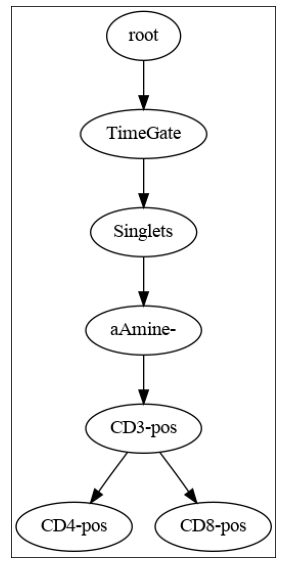

In [14]:
f = plt.figure(figsize=(12, 8))
ax = f.subplots(1)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.imshow(img)
plt.tight_layout()
plt.show()

<a id="retrieve-gate-ids"></a>
#### Retrieve all Gate IDs (with their gate paths)

In [15]:
g_strat.get_gate_ids()

[('TimeGate', ('root',)),
 ('Singlets', ('root', 'TimeGate')),
 ('aAmine-', ('root', 'TimeGate', 'Singlets')),
 ('CD3-pos', ('root', 'TimeGate', 'Singlets', 'aAmine-')),
 ('CD4-pos', ('root', 'TimeGate', 'Singlets', 'aAmine-', 'CD3-pos')),
 ('CD8-pos', ('root', 'TimeGate', 'Singlets', 'aAmine-', 'CD3-pos'))]

<a id="retrieve-gate-instances"></a>
#### Retrieve Gate Instances

Below we show retrieving a Gate instance by its gate name, which works here because the name is unambigious within this gate hierarchy. We can also retrieve a gate's parent Gate instance or the list of child gates.

In [16]:
g_strat.get_gate('TimeGate')

GMLRectangleGate(TimeGate, parent: None, dims: 2)

In [17]:
g_strat.get_parent_gate('CD3-pos')

GMLPolygonGate(aAmine-, parent: Singlets, vertices: 10)

In [18]:
g_strat.get_child_gates('CD3-pos')

[GMLPolygonGate(CD4-pos, parent: CD3-pos, vertices: 12),
 GMLPolygonGate(CD8-pos, parent: CD3-pos, vertices: 6)]

#### Retrieve Compensation Matrices

In [19]:
g_strat.comp_matrices

{'Acquisition-defined': Matrix(Acquisition-defined, dims: 8)}

#### Retrieve Transformations

In [20]:
g_strat.transformations

{'scatter-lin': LinearGMLTransform(scatter-lin, t: 262144.0, a: 0.0),
 'logicle-default': LogicleGMLTransform(logicle-default, t: 262144.0, w: 1.0, m: 4.418539922, a: 0.0),
 'Time': LinearGMLTransform(Time, t: 72.0, a: 0.8511997311)}

## GatingResults Class

A GatingResults instance is returned from calling the GatingStrategy `gate_sample` method on a Sample instance, and is never created by an end user directly. A GatingResults instance contains the results of applying the gating hierarchy on a single Sample. Let's load a Sample and apply the previous GatingStrategy via the `gate_sample` method (setting `verbose=True` to print out each gate as it is processed). 

In [21]:
sample = fk.Sample("data/8_color_data_set/fcs_files/101_DEN084Y5_15_E01_008_clean.fcs")

In [22]:
gs_results = g_strat.gate_sample(sample, verbose=True)

101_DEN084Y5_15_E01_008_clean.fcs: processing gate TimeGate
101_DEN084Y5_15_E01_008_clean.fcs: processing gate Singlets
101_DEN084Y5_15_E01_008_clean.fcs: processing gate aAmine-
101_DEN084Y5_15_E01_008_clean.fcs: processing gate CD3-pos
101_DEN084Y5_15_E01_008_clean.fcs: processing gate CD4-pos
101_DEN084Y5_15_E01_008_clean.fcs: processing gate CD8-pos


In [23]:
help(gs_results)

Help on GatingResults in module flowkit._models.gating_results object:

class GatingResults(builtins.object)
 |  GatingResults(results_dict, sample_id)
 |  
 |  A GatingResults instance is returned from the GatingStrategy `gate_samples` method
 |  as well as the Session `get_gating_results` method. End users will never create an
 |  instance of GatingResults directly, only via these GatingStrategy and Session
 |  methods. However, there are several GatingResults methods to retrieve the results.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, results_dict, sample_id)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_gate_absolute_percent(self, gate_name, gate_path=None)
 |      Retrieve percent of events, relative to the total sample events, of the specified gate ID for the
 |      gating results sample
 |      
 |      :param gate_name: text string of a gate name
 |      :param gate_path: tuple of ancestor gate names
 |      :return: floating po

In [24]:
# get the Sample ID for the GatingResults instance
gs_results.sample_id

'101_DEN084Y5_15_E01_008_clean.fcs'

### GatingResults Report

As we can see, the GatingResults class is relatively simple, and it's main purpose is to provide a Pandas DataFrame of the results via the `report` attribute. The report contains a row for every gate and includes the following columns:

* **sample**: the Sample ID of the processed Sample instance
* **gate_path**: tuple of the gate path
* **gate_name**: the name of the gate (or name of the Quadrant of a QuadrantGate)
* **gate_type**: The class name of the gate (RectangleGate, PolygonGate, etc.)
* **quadrant_parent**: Quadrant gates are a bit different, they are really a collection of gates. This field would contain the QuadrantGate name, and each Quadrant name would be in the gate_name field.
* **parent**: the gate name of the parent gate
* **count**: the absolute event count for events inside the gate
* **absolute_percent**: the percentage of events inside the gate relative to the total event count in the Sample
* **relative_percent**: the percentage of events inside the gate relative to the number of events in the parent gate
* **level**: the depth of the gate in the gate tree relative to the root of the tree

In [25]:
gs_results.report

,sample,gate_path,gate_name,gate_type,quadrant_parent,parent,count,absolute_percent,relative_percent,level
0,101_DEN084Y5_15_E01_008_clean.fcs,"(root,)",TimeGate,RectangleGate,None,None,290166,99.997932,99.997932,1
1,101_DEN084Y5_15_E01_008_clean.fcs,"(root, TimeGate)",Singlets,PolygonGate,None,TimeGate,239001,82.365287,82.366990,2
2,101_DEN084Y5_15_E01_008_clean.fcs,"(root, TimeGate, Singlets)",aAmine-,PolygonGate,None,Singlets,164655,56.743931,68.893017,3
3,101_DEN084Y5_15_E01_008_clean.fcs,"(root, TimeGate, Singlets, aAmine-)",CD3-pos,PolygonGate,None,aAmine-,133670,46.065782,81.181865,4
4,101_DEN084Y5_15_E01_008_clean.fcs,"(root, TimeGate, Singlets, aAmine-, CD3-pos)",CD4-pos,PolygonGate,None,CD3-pos,82484,28.425899,61.707189,5
5,101_DEN084Y5_15_E01_008_clean.fcs,"(root, TimeGate, Singlets, aAmine-, CD3-pos)",CD8-pos,PolygonGate,None,CD3-pos,47165,16.254153,35.284656,5


<a id="gate-membership"></a>
### Retrieve gate membership

The `get_gate_membership` method returns a Boolean array representing which of the Sample events are inside the specified gate.

In [26]:
cd3_pos_gate_membership = gs_results.get_gate_membership('CD3-pos')

In [27]:
cd3_pos_gate_membership

array([False, False, False, ..., False, False,  True])

In [28]:
cd3_pos_gate_membership.sum()

133670

We can then use the membership array to retrieve those events from the Sample

**Note: The events we extract here are not necessarily pre-processed the same as they would be given the instructions of the gate, even if using the 'comp' or 'xform' source option.  

In [29]:
gated_raw_events = sample.get_events(source='raw')
gated_raw_events = gated_raw_events[cd3_pos_gate_membership]

In [30]:
gated_raw_events.shape

(133670, 15)